In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
! pip install gower
! pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from kmodes.kmodes import KModes
import gower
import pickle
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import random
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [ ]:
# read the dataset
dataset = pd.read_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/Crashes.csv")

There are 49 columns in the dataset, we are dropping 31 columns which are unrelated to the research questions of our project and the cause of accidents.

In [ ]:
dataset = dataset.drop(['CRASH_RECORD_ID', 'RD_NO', "NUM_UNITS", 'ALIGNMENT', 'CRASH_DATE_EST_I', 'STREET_DIRECTION', "MOST_SEVERE_INJURY", "INJURIES_TOTAL" ,'CRASH_DATE', 'STREET_NAME', 'REPORT_TYPE', 'CRASH_TYPE', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DATE_POLICE_NOTIFIED', 'STREET_NO', 'INTERSECTION_RELATED_I', 'BEAT_OF_OCCURRENCE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'LANE_CNT', 'INJURIES_NON_INCAPACITATING' , 'INJURIES_REPORTED_NOT_EVIDENT' , 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN' ], axis=1)

Fill the missing values in the dataframe with a value '-1'

In [ ]:
dataset['LATITUDE'] = dataset['LATITUDE'].fillna('-1')
dataset['LONGITUDE'] = dataset['LONGITUDE'].fillna('-1')
dataset['LOCATION'] = dataset['LOCATION'].fillna('-1')

Remove points with missing lat long

In [ ]:
dataset = dataset[dataset.LATITUDE != "-1"]
dataset = dataset[dataset.LONGITUDE != "-1"]


In [ ]:
dataset = dataset[dataset.LATITUDE != 0.0]
dataset = dataset[dataset.LONGITUDE != 0.0]

In [ ]:
dataset.columns

Index(['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'DAMAGE',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE',
       'LOCATION'],
      dtype='object')

In [ ]:
dataset = dataset.reset_index(drop = True)

We then convert our categorical attributes to numeric label data.

In [ ]:
columns = list(dataset.columns)
columns_to_remove = ['CRASH_HOUR','CRASH_DAY_OF_WEEK','CRASH_MONTH','LATITUDE','LONGITUDE']
for rem in columns_to_remove:
  columns.remove(rem)

df = pd.DataFrame()
le_list = []

for column in columns:
  le = preprocessing.LabelEncoder() 
  le.fit(list(dataset[column]))
  column_name = column + "_TRANSFORMED"
  df[column_name] = le.transform(list(dataset[column]))
  le_list.append(le)

In [ ]:
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/le_list.pkl', 'wb') as f:
    pickle.dump(le_list, f)

In [ ]:
for elem in columns_to_remove:
  df[elem] = dataset[elem]

Save the preprocessed dataset in a new csv, next time just load the processed csv

In [ ]:
#df.to_csv('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/Crashes_processed.csv', index = False)
dataset.to_csv('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/Crashes_processed_part2.csv', index = False)

### Load the preprocessed dataset

In [25]:
# run this
#df = pd.read_csv('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/Crashes_processed.csv')
df = pd.read_csv('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/Crashes_processed_part2.csv')

In [ ]:
df.head()

POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
0                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
1                  30            NO CONTROLS           NO CONTROLS   
2                  30                UNKNOWN               UNKNOWN   
3                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
4                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   

  WEATHER_CONDITION      LIGHTING_CONDITION FIRST_CRASH_TYPE TRAFFICWAY_TYPE  \
0             CLEAR                DAYLIGHT          TURNING         ONE-WAY   
1             CLEAR                DAYLIGHT            ANGLE     NOT DIVIDED   
2             CLEAR  DARKNESS, LIGHTED ROAD            ANGLE     NOT DIVIDED   
3             CLEAR                DAYLIGHT         REAR END        FOUR WAY   
4             CLEAR                DAYLIGHT         REAR END     NOT DIVIDED   

  ROADWAY_SURFACE_COND ROAD_DEFECT         DAMAGE  \
0                  DRY  NO DEFECTS    OVER $1,500   
1                  DRY  NO DEFECTS    OVER $1,500   
2                  DRY     UNKNOWN    OVER $1,500   
3                  DRY  NO DEFECTS  $501 - $1,500   
4                  DRY  NO DEFECTS    OVER $1,500   

                             PRIM_CONTRIBUTORY_CAUSE  \
0                         IMPROPER TURNING/NO SIGNAL   
1  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...   
2                                UNABLE TO DETERMINE   
3                       DISREGARDING TRAFFIC SIGNALS   
4                                UNABLE TO DETERMINE   

                SEC_CONTRIBUTORY_CAUSE  CRASH_HOUR  CRASH_DAY_OF_WEEK  \
0  DRIVING SKILLS/KNOWLEDGE/EXPERIENCE          14                  2   
1        FAILING TO YIELD RIGHT-OF-WAY           8                  4   
2                  UNABLE TO DETERMINE           0                  6   
3                       NOT APPLICABLE          11                  2   
4                  UNABLE TO DETERMINE          18                  6   

   CRASH_MONTH   LATITUDE  LONGITUDE                                  LOCATION  
0            3  41.884547 -87.641201   POINT (-87.64120093714 41.884547224337)  
1            9  41.968562 -87.740659  POINT (-87.740659314632 41.968562453871)  
2            7  41.886336 -87.716203  POINT (-87.716203130599 41.886336409761)  
3            8  41.749348 -87.721097  POINT (-87.721096727406 41.749348170421)  
4            7  41.925111 -87.667997  POINT (-87.667997321599 41.925110815832)

In [ ]:
df.columns

Index(['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'DAMAGE',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE',
       'LOCATION'],
      dtype='object')

## PCA
### We take all our features, project them onto a lower-dimensional space, reduce them down to just a few important principal ones, and visualize them.

In [ ]:
# run this
# Dimensionality reduction by PCA. We will try to find the optimal number of components which capture the greatest amount of variance in the data.
X = df.copy()
X = X.drop(["LATITUDE", "LONGITUDE"], axis = 1)

In [ ]:
# Create a PCA instance: pca
pca = PCA(n_components=16)
principalComponents = pca.fit_transform(X)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

ValueError: ignored

Text(0, 0.5, 'PCA 2')

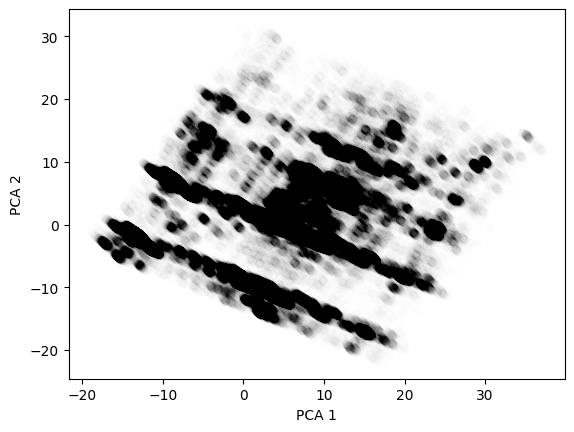

In [ ]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.003, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

We can see from the principle component analysis that there are 7 very visible clusters.
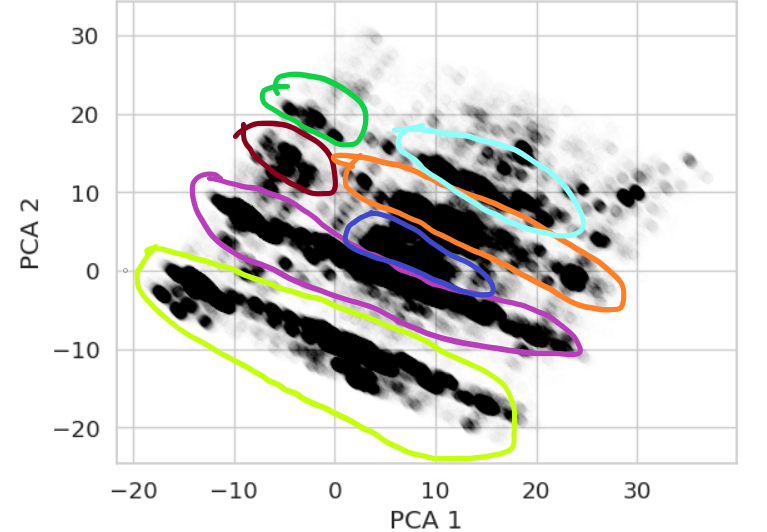

### Find optimal K

In [ ]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init = "auto")
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

We can see that the most rapidly changing points resides at k = 2. And after k = 6 the change becomes very small.

# Clustering Algorithms (Potential Factors + Times)

## 1) Kmeans

In [ ]:
# run this
model = KMeans(n_clusters=2)
model.fit(X)
clusters_2 = model.labels_

model = KMeans(n_clusters=5)
model.fit(X)
clusters_5 = model.labels_

#### Cluster validation

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        print("KMeans with cluster = 2 SWC score: ", metrics.silhouette_score(X, clusters_2, metric='euclidean'))
gpu()

KMeans with cluster = 2 SWC score:  0.24509034581154765


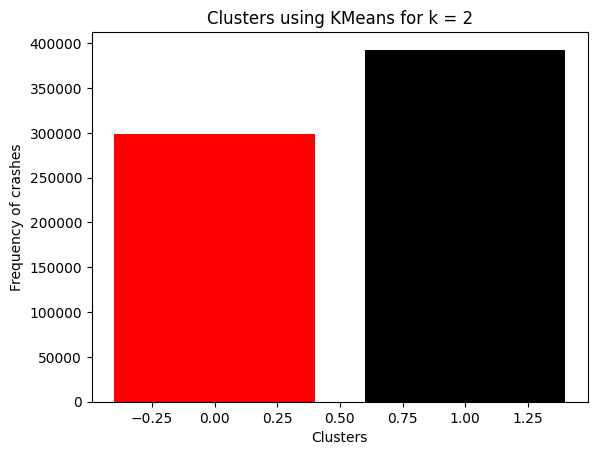

In [ ]:
#run this
cluster_labels = [0,1]
frequency = [list(clusters_2).count(0), list(clusters_2).count(1)]

bar = plt.bar(cluster_labels, frequency, color = ['red', 'black'])

plt.title("Clusters using KMeans for k = 2")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

In [ ]:
# run this
cluster_labels = [0,1,2,3,4]
frequency = [list(clusters_5).count(0), list(clusters_5).count(1), list(clusters_5).count(2), list(clusters_5).count(3), list(clusters_5).count(4)]

bar = plt.bar(cluster_labels, frequency, color = ['red', 'black', 'blue', 'green', 'yellow'])

plt.title("Clusters using KMeans for k = 5")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

### Insights

In [ ]:
# run this
X_kmeans_insight = X.copy()
X_kmeans_insight["KMEANS_2"] = list(clusters_2)
X_kmeans_insight["KMEANS_5"] = list(clusters_5)

In [ ]:
# run this
X_kmeans_insight_cluster2 = X_kmeans_insight[X_kmeans_insight["KMEANS_5"] == 2]

In [ ]:
# run this
X_kmeans_insight_cluster2["LATITUDE"] = df["LATITUDE"]
X_kmeans_insight_cluster2["LONGITUDE"] = df["LONGITUDE"]

In [ ]:
# run this
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/le_list.pkl', 'rb') as f:
    le_list = pickle.load(f)

In [ ]:
# run this
X_kmeans_insight_cluster2["WEATHER_CONDITION_TRANSFORMED"].value_counts()

2     113991
7      12493
3       4582
11      4005
10      3855
6        338
4        212
5        209
9        175
1         51
8         23
0          1
Name: WEATHER_CONDITION_TRANSFORMED, dtype: int64

In [ ]:
weather_le = le_list[3]
output = list(weather_le.inverse_transform([2,7,3,11,10]))
print(output)

['CLEAR', 'RAIN', 'CLOUDY/OVERCAST', 'UNKNOWN', 'SNOW']


In [ ]:
X_kmeans_insight_cluster2['PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED'].value_counts()

18    29073
19    28151
17    11244
23    10447
6     10192
24    10081
26     9830
22     7758
5      5725
12     4250
21     3507
8      1647
13     1016
28      987
3       941
11      903
9       790
15      590
16      555
2       378
4       300
30      258
14      257
36      238
20      152
7       133
37      120
10      110
0        97
32       35
35       32
1        30
38       23
27       20
34       20
33       14
25       12
31        8
39        6
29        5
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
prim_le = le_list[11]
output = list(prim_le.inverse_transform([18,19,17,23,6]))
print(output)

['FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY', 'FAILING TO REDUCE SPEED TO AVOID CRASH', 'IMPROPER OVERTAKING/PASSING', 'DISREGARDING TRAFFIC SIGNALS']


This is interesting, as we can see that the top 5 primary contributing causes of the accidents in this cluster were ['FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY', 'FAILING TO REDUCE SPEED TO AVOID CRASH', 'IMPROPER OVERTAKING/PASSING', 'DISREGARDING TRAFFIC SIGNALS'] The accidents in this cluster are caused mostly by speeding.

In [ ]:
X_kmeans_insight_cluster1 = X_kmeans_insight[X_kmeans_insight["KMEANS_5"] == 1]

In [ ]:
X_kmeans_insight_cluster1["LATITUDE"] = df["LATITUDE"]
X_kmeans_insight_cluster1["LONGITUDE"] = df["LONGITUDE"]

In [ ]:
X_kmeans_insight_cluster1['PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED'].value_counts()

36    172676
39      6396
30      2425
38      2394
28      2259
37      2197
33      1373
32       987
26       358
31       143
34       117
35        31
29        30
27         5
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
prim_le = le_list[11]
output = list(prim_le.inverse_transform([36,39,30,38,28]))
print(output)

['UNABLE TO DETERMINE', 'WEATHER', 'PHYSICAL CONDITION OF DRIVER', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER']


This is interesting, as we can see that the top 5 primary contributing causes of the accidents in cluster 1 were ['UNABLE TO DETERMINE', 'WEATHER', 'PHYSICAL CONDITION OF DRIVER', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER'] The accidents in this cluster were caused by the negligence of the drivers mainly.

# Take a sample of the data for DBSCAN and OPTICS

In [ ]:
X_new = X.sample(frac=1)
X_new = X_new[:50000]
X_new.to_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/X_dbscan_optics.csv")

NameError: ignored

In [ ]:
# run this
X_new = pd.read_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/X_dbscan_optics.csv")

In [ ]:
# run this
X_DBSCAN = X_new.copy()
X_DBSCAN = X_DBSCAN.drop(["Unnamed: 0"], axis= 1)

## 2) DBSCAN

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = DBSCAN(eps=5, min_samples=10)
      # fit model and predict clusters
        yhat = model.fit_predict(X_DBSCAN)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
dbscan_labels = gpu()


In [ ]:
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/dbscan_labels.pkl', 'wb') as f:
    pickle.dump(dbscan_labels, f)

In [ ]:
# run this
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/dbscan_labels.pkl', 'rb') as f:
    dbscan_labels = pickle.load(f)

#### Cluster validation

In [ ]:
# cluster validation
print("DBSCAN SWC score: ", metrics.silhouette_score(X_DBSCAN, dbscan_labels, metric='euclidean'))

Capture.JPG

In [ ]:
# run this
cluster_labels = list(set(list(dbscan_labels)))
cluster_labels.sort()

frequency = []
for i in cluster_labels:
    frequency.append(list(dbscan_labels).count(i))
bar = plt.bar(cluster_labels, frequency, color=plt.cm.Paired(np.arange(len(cluster_labels))))

plt.title("Clusters using DBSCAN")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
plt.ylim(0,400)
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

## 3) Optics

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = OPTICS(eps=10, min_samples=40)
        # fit model and predict clusters
        yhat = model.fit_predict(X_DBSCAN)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
optics_labels = gpu()

In [ ]:
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/optics_labels.pkl', 'wb') as f:
    pickle.dump(optics_labels, f)

In [ ]:
# run this
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/optics_labels.pkl', 'rb') as f:
    optics_labels = pickle.load(f)

#### Cluster validation

In [ ]:
# cluster validation
print("OPTICS SWC score: ", metrics.silhouette_score(X_DBSCAN, optics_labels, metric='euclidean'))

Capture2.JPG

In [ ]:
# run this
cluster_labels = list(set(list(optics_labels)))
cluster_labels.sort()

frequency = []
for i in cluster_labels:
    frequency.append(list(optics_labels).count(i))
bar = plt.bar(cluster_labels, frequency, color=plt.cm.Dark2(np.arange(len(cluster_labels))))

plt.title("Clusters using OPTICS")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
plt.ylim(0,400)
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

## 4) Agglomerative Clustering

In [ ]:
def gpu():
    with tf.device('/GPU:0'):
        model = AgglomerativeClustering(n_clusters = 5)
      # fit model and predict clusters
        yhat = model.fit_predict(X_DBSCAN[40000:50000])
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
hierarchical_labels = gpu()
hierarchical_labels1 = gpu()
hierarchical_labels2 = gpu()


In [ ]:
hierarchical_labels = [*hierarchical_labels, *hierarchical_labels1, *hierarchical_labels2] 

In [ ]:
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/hierarchical_labels.pkl', 'wb') as f:
    pickle.dump(hierarchical_labels, f)

In [ ]:
# run this
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/hierarchical_labels.pkl', 'rb') as f:
    hierarchical_labels = pickle.load(f)

#### Cluster validation

In [ ]:
# cluster validation
print("Hierarchical SWC score: ", metrics.silhouette_score(X_DBSCAN, hierarchical_labels, metric='euclidean'))

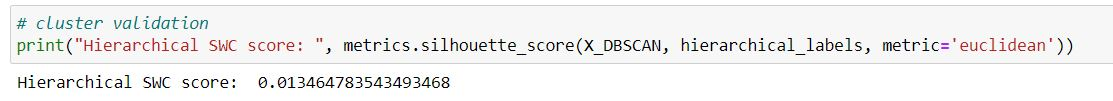

In [ ]:
# run this
cluster_labels = list(set(list(hierarchical_labels)))
cluster_labels.sort()

frequency = []
for i in cluster_labels:
    frequency.append(list(hierarchical_labels).count(i))
bar = plt.bar(cluster_labels, frequency, color=plt.cm.Dark2(np.arange(len(cluster_labels))))

plt.title("Clusters using Agglomerative Clustering")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
# plt.ylim(0,400)
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

# Get insights from these clusters and preprocess the data for visualization

In [ ]:
X_DBSCAN["DBSCAN_LABELS"] = list(dbscan_labels)
X_DBSCAN["OPTICS_LABELS"] = list(optics_labels)
X_DBSCAN["HIERARCHICAL_LABELS"]  = list(hierarchical_labels)


In [ ]:
X_DBSCAN["ORIGINAL_INDEX"] = X_new["Unnamed: 0"]

In [ ]:
latitudes = []
longitudes = []
for i in range(len(X_DBSCAN)):
  latitudes.append(df["LATITUDE"][X_DBSCAN['ORIGINAL_INDEX'][i]])
  longitudes.append(df["LONGITUDE"][X_DBSCAN['ORIGINAL_INDEX'][i]])

X_DBSCAN["LATITUDE"] = latitudes
X_DBSCAN["LONGITUDE"] = longitudes

In [ ]:
X_DBSCAN.to_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/X_dbscan_optics_label_lat_lon.csv", index = False)

In [ ]:
# run this
X_dbscan_optics = pd.read_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/X_dbscan_optics_label_lat_lon.csv")

## DBSCAN insights for the primary cause of the accidents

In [ ]:
X_dbscan_cluster0 = X_dbscan_optics[X_dbscan_optics["DBSCAN_LABELS"] == 0]
X_dbscan_cluster3 = X_dbscan_optics[X_dbscan_optics["DBSCAN_LABELS"] == 3]

In [ ]:
X_dbscan_cluster0['PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED'].value_counts()

36    19153
18     5439
19     4946
26     2578
23     2363
17     2184
21     2038
22     1843
24     1620
12     1569
6       920
39      812
28      650
5       537
8       345
13      320
30      294
38      273
37      251
11      250
9       195
15      144
32      131
16      122
3       116
33      112
14       97
4        67
2        67
20       53
35       38
0        27
10       21
31       16
34       16
7        15
27        5
25        2
1         2
29        2
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
prim_le = le_list[11]
output = list(prim_le.inverse_transform([36,18,19, 26,23]))
print(output)

['UNABLE TO DETERMINE', 'FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY', 'NOT APPLICABLE', 'IMPROPER OVERTAKING/PASSING']


In [ ]:
X_dbscan_cluster3['PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED'].value_counts()

36    6
38    1
30    1
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
output = list(prim_le.inverse_transform([36,38,30]))
print(output)

['UNABLE TO DETERMINE', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 'PHYSICAL CONDITION OF DRIVER']


## Hierarchical clustering insights for the primary cause of the accidents

In [ ]:
X_hier_cluster0 = X_dbscan_optics[X_dbscan_optics["HIERARCHICAL_LABELS"] == 0]
X_hier_cluster4 = X_dbscan_optics[X_dbscan_optics["HIERARCHICAL_LABELS"] == 4]

In [ ]:
X_hier_cluster0['PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED'].value_counts()

36    8626
18     819
19     812
26     387
17     334
39     330
24     321
6      316
23     285
22     200
12     198
5      163
38     140
28     127
37     117
21     107
30      86
8       73
32      52
33      51
13      50
3       38
11      32
9       31
16      29
15      25
35      14
4       13
2       11
14       8
34       7
20       6
10       5
31       4
7        4
0        3
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
X_hier_cluster4['PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED'].value_counts()

36    5174
18     349
19     308
26     266
39     262
23     211
21     168
22     153
17     151
12     133
24      96
28      72
38      62
37      49
8       39
30      35
11      34
32      30
13      29
35      21
9       19
33      18
16      10
15      10
4        7
2        6
14       6
34       6
5        5
20       3
3        3
10       3
0        3
31       2
7        1
6        1
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
output = list(prim_le.inverse_transform([36,18,19]))
print(output)

['UNABLE TO DETERMINE', 'FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY']


# Visualization

### DBSCAN clusters

In [ ]:
fig = px.scatter_mapbox(X_dbscan_optics, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="DBSCAN_LABELS",
                        zoom=8, 
                        height=500,
                        width=1200)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
X_dbscan_optics["DBSCAN_LABELS"].value_counts()

 0    49633
-1      275
 1       37
 2       21
 5       13
 4       13
 3        8
Name: DBSCAN_LABELS, dtype: int64

### Optics Clusters

In [ ]:
cluster_labels = list(set(list(optics_labels)))
cluster_labels.sort()
colors=plt.cm.Dark2(np.arange(len(cluster_labels)))
#print(colors)

fig = px.scatter_mapbox(X_dbscan_optics, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="OPTICS_LABELS",
                        zoom=8, 
                        height=500,
                        width=1200)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
X_dbscan_optics["OPTICS_LABELS"].value_counts()

-1    49766
 2       90
 0       55
 3       45
 1       44
Name: OPTICS_LABELS, dtype: int64

### Hierarchical Clusters

In [ ]:
cluster_labels = list(set(list(hierarchical_labels)))
cluster_labels.sort()
colors=plt.cm.Dark2(np.arange(len(cluster_labels)))
#print(colors)

fig = px.scatter_mapbox(X_dbscan_optics, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="HIERARCHICAL_LABELS",
                        zoom=8, 
                        height=500,
                        width=1200)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### KMeans Clusters (k = 2)

In [ ]:
X_KMEANS = X.copy()

In [ ]:
X_KMEANS["KMEANS_2"] = list(clusters_2)
X_KMEANS["KMEANS_5"] = list(clusters_5)

In [ ]:
X_KMEANS["LATITUDE"] = df["LATITUDE"]
X_KMEANS["LONGITUDE"] = df["LONGITUDE"]

In [ ]:
X_KMEANS_sample = X_KMEANS.sample(frac = 1)[:50000]

In [ ]:
fig = px.scatter_mapbox(X_KMEANS_sample, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="KMEANS_2",
                        zoom=8, 
                        height=500,
                        width=1200)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### KMeans Clusters (k = 5)

In [ ]:
fig = px.scatter_mapbox(X_KMEANS_sample, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="KMEANS_5",
                        zoom=8, 
                        height=500,
                        width=1200)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Research Questions


## Correlation between different factors

In [ ]:
# run this
X_factors = df[['TRAFFIC_CONTROL_DEVICE_TRANSFORMED','DEVICE_CONDITION_TRANSFORMED', 'WEATHER_CONDITION_TRANSFORMED','LIGHTING_CONDITION_TRANSFORMED', 'FIRST_CRASH_TYPE_TRANSFORMED', 'ROADWAY_SURFACE_COND_TRANSFORMED', 'ROAD_DEFECT_TRANSFORMED', 'PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED','SEC_CONTRIBUTORY_CAUSE_TRANSFORMED', "CRASH_DAY_OF_WEEK", "CRASH_HOUR", "LOCATION_TRANSFORMED"]]

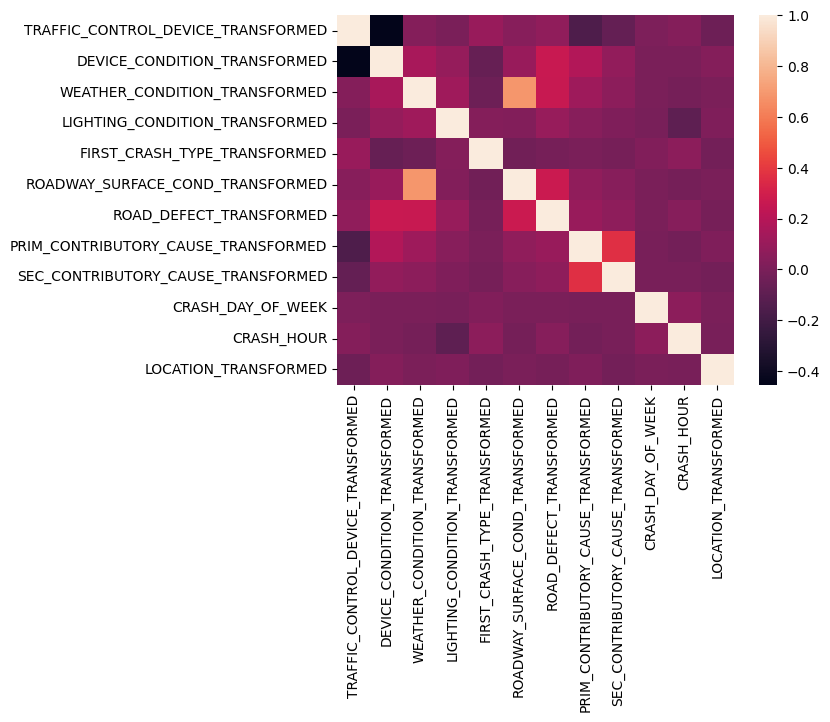

In [ ]:
# run this
sns.heatmap(X_factors.corr());

## RQ1: When do the crashes happen more often?

## At first let's consider the time and day of the week only for clustering

In [53]:
# run this
X = df[['CRASH_HOUR', 'CRASH_DAY_OF_WEEK']].copy()

## 1) K-Means

### Find the suitable k-value for this scenario

In [ ]:
# code collected from https://builtin.com/data-science/data-clustering-python
# the sum of the squared distance between each member of the cluster and its centroid
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto")
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

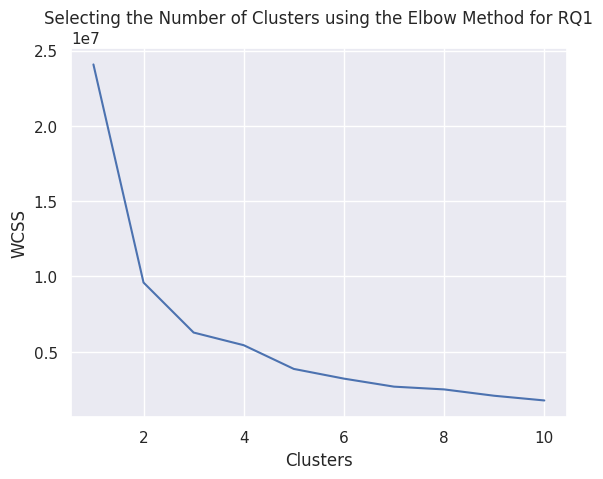

In [ ]:
sns.set()
plt.plot(range(1, 11), wcss)
plt.title('Selecting the Number of Clusters using the Elbow Method for RQ1')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Optimal_K_KMeans.png')
plt.show()

From the elbow method we can see that the optimal number of clusters should be between 2 to 5 as this is where the elbow resides. For our projects, we are selecting k = 5.

In [54]:
# run this
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto")
kmeans.fit(X)
clusters = kmeans.labels_

In [55]:
X["KMEANS_LABEL"] = clusters

In [56]:
X_data = X.sample(frac = 1)[:10000]

In [59]:
labels = X_data["KMEANS_LABEL"]
X_data = X_data.drop(["KMEANS_LABEL"], axis = 1)
metrics.silhouette_score(X_data, labels, metric='euclidean')

0.3785002473855373

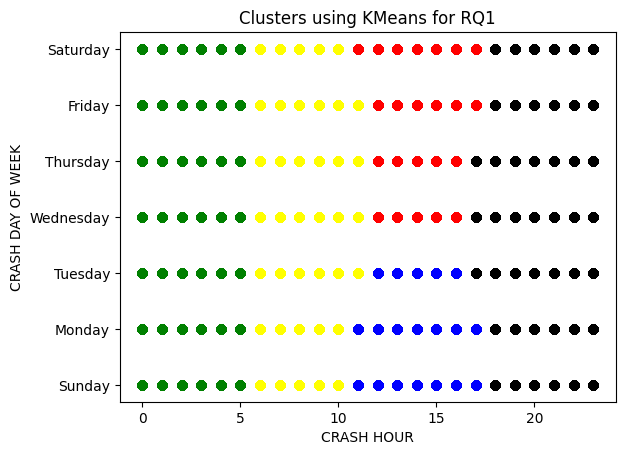

In [ ]:
# run this
filtered_label0 = X[clusters == 0]
filtered_label1 = X[clusters == 1]
filtered_label2 = X[clusters == 2]
filtered_label3 = X[clusters == 3]
filtered_label4 = X[clusters == 4]

plt.scatter(filtered_label0["CRASH_HOUR"] , filtered_label0["CRASH_DAY_OF_WEEK"] , c = 'red')
plt.scatter(filtered_label1["CRASH_HOUR"] , filtered_label1["CRASH_DAY_OF_WEEK"] , c = 'black')
plt.scatter(filtered_label2["CRASH_HOUR"] , filtered_label2["CRASH_DAY_OF_WEEK"] , c = 'green')
plt.scatter(filtered_label3["CRASH_HOUR"] , filtered_label3["CRASH_DAY_OF_WEEK"] , c = 'blue')
plt.scatter(filtered_label4["CRASH_HOUR"] , filtered_label4["CRASH_DAY_OF_WEEK"] , c = 'yellow')

plt.title("Clusters using KMeans for RQ1")
plt.xlabel("CRASH HOUR")
plt.ylabel("CRASH DAY OF WEEK")
# plt.xticks(np.arange(5), ('Before Dawn', 'Peak (AM)', 'Office Hours', 'Peak (PM)', 'Evening'))
plt.yticks(np.arange(1,8), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "Saturday"))
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans.png')
plt.show()

We can see that using KMeans the more prominent clusters are formed in:

1.   Sunday to Saturday from midnight to 5am (Before dawn)
2.   Sunday to Saturday from 5am to 11am (Morning)
3.   Sunday to Tuesday from 11am to 7pm (Office Hours + after office hours)
4.   Wednesday to Saturday from 12pm to 4pm (Late office hours)
5.   Sunday to Saturday from 6pm to midnight (Evening)

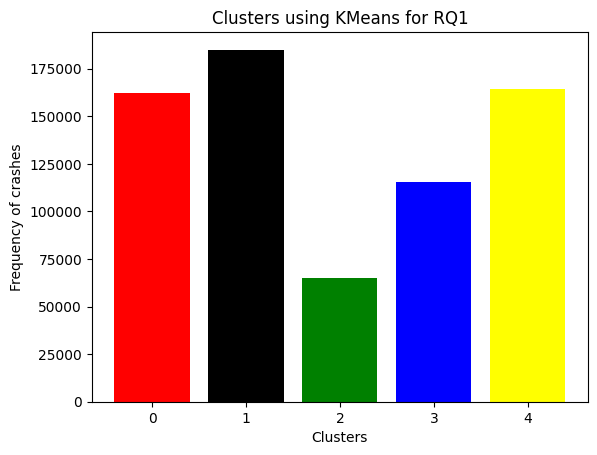

In [ ]:
clusters = kmeans.labels_

filtered_label0 = len(X[clusters == 0])
filtered_label1 = len(X[clusters == 1])
filtered_label2 = len(X[clusters == 2])
filtered_label3 = len(X[clusters == 3])
filtered_label4 = len(X[clusters == 4])

cluster_labels = [0,1,2, 3,4]
frequency = [filtered_label0, filtered_label1, filtered_label2, filtered_label3, filtered_label4]

bar = plt.bar(cluster_labels, frequency, color = ['red', 'black', 'green', 'blue', 'yellow'])

plt.title("Clusters using KMeans for RQ1")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

**We can see that the most crashes happen during evening to midnight**

## 2) DBSCAN

In [ ]:
X = df[['CRASH_HOUR', 'CRASH_DAY_OF_WEEK']].copy()
X_DBSCAN = X.sample(frac = 1)[:1000]

In [ ]:
X_DBSCAN = X_DBSCAN.reset_index()

In [ ]:
X_DBSCAN.to_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/X_DBSCAN_time.csv", index = False)

In [65]:
# run this
X_DBSCAN = pd.read_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/X_DBSCAN_time.csv")

In [66]:
# run this
X_DBSCAN_new = X_DBSCAN.drop(["index"], axis = 1)

In [67]:
# run this
model = DBSCAN(eps=0.005, min_samples=15)
yhat = model.fit_predict(X_DBSCAN_new)
clusters = np.unique(yhat)
noise = 0
if list(clusters).count(-1) > 0:
    noise = 1
print("Number of clusters: ", len(clusters) - noise)
print("Number of noise points: ", list(yhat).count(-1))

Number of clusters:  6
Number of noise points:  894


In [68]:
X_DBSCAN_new["DBSCAN_LABELS"] = list(yhat)

In [69]:
X_DBSCAN_new = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] != -1]

In [70]:
labels = X_DBSCAN_new["DBSCAN_LABELS"]
X_data = X_DBSCAN_new.drop(["DBSCAN_LABELS"], axis = 1)
metrics.silhouette_score(X_data, labels, metric='euclidean')

1.0

In [ ]:
X_DBSCAN_new["ORIGINAL_INDEX"] = X_DBSCAN["index"]

In [ ]:
latitudes = []
longitudes = []
for i in range(len(X_DBSCAN)):
  latitudes.append(df["LATITUDE"][X_DBSCAN_new['ORIGINAL_INDEX'][i]])
  longitudes.append(df["LONGITUDE"][X_DBSCAN_new['ORIGINAL_INDEX'][i]])

X_DBSCAN_new["LATITUDE"] = latitudes
X_DBSCAN_new["LONGITUDE"] = longitudes

In [ ]:
X_DBSCAN_new["DBSCAN_LABELS"].value_counts()

-1    894
 3     20
 4     20
 2     18
 1     17
 5     16
 0     15
Name: DBSCAN_LABELS, dtype: int64

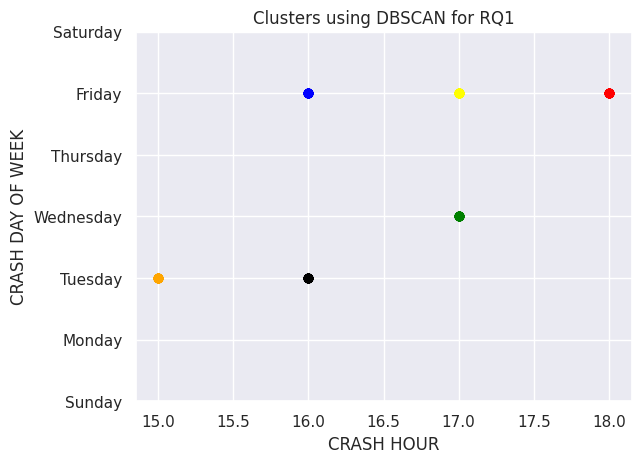

In [ ]:
# run this
filtered_label0 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 0]
filtered_label1 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 1]
filtered_label2 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 2]
filtered_label3 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 3]
filtered_label4 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 4]
filtered_label5 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 5]

plt.scatter(filtered_label0["CRASH_HOUR"] , filtered_label0["CRASH_DAY_OF_WEEK"] , c = 'red')
plt.scatter(filtered_label1["CRASH_HOUR"] , filtered_label1["CRASH_DAY_OF_WEEK"] , c = 'black')
plt.scatter(filtered_label2["CRASH_HOUR"] , filtered_label2["CRASH_DAY_OF_WEEK"] , c = 'green')
plt.scatter(filtered_label3["CRASH_HOUR"] , filtered_label3["CRASH_DAY_OF_WEEK"] , c = 'blue')
plt.scatter(filtered_label4["CRASH_HOUR"] , filtered_label4["CRASH_DAY_OF_WEEK"] , c = 'yellow')
plt.scatter(filtered_label5["CRASH_HOUR"] , filtered_label5["CRASH_DAY_OF_WEEK"] , c = 'orange')

plt.title("Clusters using DBSCAN for RQ1")
plt.xlabel("CRASH HOUR")
plt.ylabel("CRASH DAY OF WEEK")
# plt.xticks(np.arange(5), ('Before Dawn', 'Peak (AM)', 'Office Hours', 'Peak (PM)', 'Evening'))
plt.yticks(np.arange(1,8), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "Saturday"))
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans.png')
plt.show()

### Analyze the most frequent cluster label in DBSCAN

In [ ]:
X_cluster3 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 3]

In [ ]:
print(X_cluster3["CRASH_HOUR"].value_counts())
print(X_cluster3["CRASH_DAY_OF_WEEK"].value_counts())

16    20
Name: CRASH_HOUR, dtype: int64
6    20
Name: CRASH_DAY_OF_WEEK, dtype: int64


**We can see that the most frequent cluster in DBSCAN considering only the time was formed in 4pm Friday.**

## 3) Optics

In [71]:
X_DBSCAN = pd.read_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/X_DBSCAN_time.csv")
X_DBSCAN_new = X_DBSCAN.drop(["index"], axis = 1)

model = OPTICS(eps=0.005, min_samples=15)
# fit model and predict clusters
yhat = model.fit_predict(X_DBSCAN_new)
# retrieve unique clusters
clusters = np.unique(yhat)
noise = 0
if list(clusters).count(-1) > 0:
    noise = 1
print("Number of clusters: ", len(clusters) - noise)
print("Number of noise points: ", list(yhat).count(-1))

Number of clusters:  8
Number of noise points:  811


In [72]:
X_DBSCAN_new["OPTICS_LABELS"] = list(yhat)

In [73]:
X_DBSCAN_new = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] != -1]

In [74]:
labels = X_DBSCAN_new["OPTICS_LABELS"]
X_data = X_DBSCAN_new.drop(["OPTICS_LABELS"], axis = 1)
metrics.silhouette_score(X_data, labels, metric='euclidean')

0.7729524569698093

In [ ]:
X_DBSCAN_new["ORIGINAL_INDEX"] = X_DBSCAN["index"]

In [ ]:
latitudes = []
longitudes = []
for i in range(len(X_DBSCAN_new)):
  latitudes.append(df["LATITUDE"][X_DBSCAN_new['ORIGINAL_INDEX'][i]])
  longitudes.append(df["LONGITUDE"][X_DBSCAN_new['ORIGINAL_INDEX'][i]])

X_DBSCAN_new["LATITUDE"] = latitudes
X_DBSCAN_new["LONGITUDE"] = longitudes

In [ ]:
X_DBSCAN_new["OPTICS_LABELS"].value_counts()

-1    811
 7     48
 6     28
 0     24
 4     20
 2     20
 1     18
 5     16
 3     15
Name: OPTICS_LABELS, dtype: int64

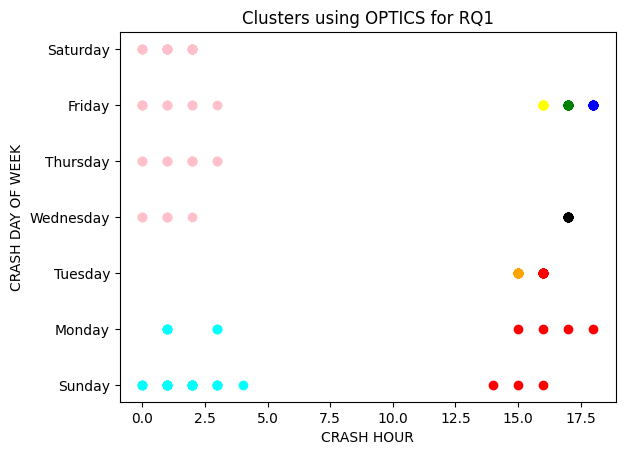

In [ ]:
# run this
filtered_label0 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 0]
filtered_label1 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 1]
filtered_label2 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 2]
filtered_label3 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 3]
filtered_label4 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 4]
filtered_label5 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 5]
filtered_label6 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 6]
filtered_label7 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 7]

plt.scatter(filtered_label0["CRASH_HOUR"] , filtered_label0["CRASH_DAY_OF_WEEK"] , c = 'red')
plt.scatter(filtered_label1["CRASH_HOUR"] , filtered_label1["CRASH_DAY_OF_WEEK"] , c = 'black')
plt.scatter(filtered_label2["CRASH_HOUR"] , filtered_label2["CRASH_DAY_OF_WEEK"] , c = 'green')
plt.scatter(filtered_label3["CRASH_HOUR"] , filtered_label3["CRASH_DAY_OF_WEEK"] , c = 'blue')
plt.scatter(filtered_label4["CRASH_HOUR"] , filtered_label4["CRASH_DAY_OF_WEEK"] , c = 'yellow')
plt.scatter(filtered_label5["CRASH_HOUR"] , filtered_label5["CRASH_DAY_OF_WEEK"] , c = 'orange')
plt.scatter(filtered_label6["CRASH_HOUR"] , filtered_label6["CRASH_DAY_OF_WEEK"] , c = 'cyan')
plt.scatter(filtered_label7["CRASH_HOUR"] , filtered_label7["CRASH_DAY_OF_WEEK"] , c = 'pink')

plt.title("Clusters using OPTICS for RQ1")
plt.xlabel("CRASH HOUR")
plt.ylabel("CRASH DAY OF WEEK")
# plt.xticks(np.arange(5), ('Before Dawn', 'Peak (AM)', 'Office Hours', 'Peak (PM)', 'Evening'))
plt.yticks(np.arange(1,8), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "Saturday"))
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans.png')
plt.show()

Analyze the most frequent cluster label in Optics

In [ ]:
X_cluster7 = X_DBSCAN_new[X_DBSCAN_new["OPTICS_LABELS"] == 7]

In [ ]:
print(X_cluster7["CRASH_HOUR"].value_counts())
print(X_cluster7["CRASH_DAY_OF_WEEK"].value_counts())

1    18
2    15
0    12
3     3
Name: CRASH_HOUR, dtype: int64
7    21
5    11
6    10
4     6
Name: CRASH_DAY_OF_WEEK, dtype: int64


In [ ]:
# run this
filtered_label0 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 0]
filtered_label1 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 1]
filtered_label2 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 2]
filtered_label3 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 3]
filtered_label4 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 4]
filtered_label5 = X_DBSCAN_new[X_DBSCAN_new["DBSCAN_LABELS"] == 5]

plt.scatter(filtered_label0["CRASH_HOUR"] , filtered_label0["CRASH_DAY_OF_WEEK"] , c = 'red')
plt.scatter(filtered_label1["CRASH_HOUR"] , filtered_label1["CRASH_DAY_OF_WEEK"] , c = 'black')
plt.scatter(filtered_label2["CRASH_HOUR"] , filtered_label2["CRASH_DAY_OF_WEEK"] , c = 'green')
plt.scatter(filtered_label3["CRASH_HOUR"] , filtered_label3["CRASH_DAY_OF_WEEK"] , c = 'blue')
plt.scatter(filtered_label4["CRASH_HOUR"] , filtered_label4["CRASH_DAY_OF_WEEK"] , c = 'yellow')
plt.scatter(filtered_label5["CRASH_HOUR"] , filtered_label5["CRASH_DAY_OF_WEEK"] , c = 'orange')

plt.title("Clusters using KMeans for RQ1")
plt.xlabel("CRASH HOUR")
plt.ylabel("CRASH DAY OF WEEK")
# plt.xticks(np.arange(5), ('Before Dawn', 'Peak (AM)', 'Office Hours', 'Peak (PM)', 'Evening'))
plt.yticks(np.arange(1,8), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "Saturday"))
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans.png')
plt.show()

**We can see that the most frequent cluster in OPTICS considering only the time was formed in 4pm Friday.**

# RQ2: What are the most accident prone areas of the city?

## 1) Agglomerative clustering

In [ ]:
# run this
X_hier = df.copy()
X_hier_loc = X_hier[["LATITUDE", "LONGITUDE"]].copy()
X_hier_loc = X_hier_loc.sample(frac = 1)[:10000]
X_hier_loc.to_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/location_sample_part2.csv", index=False)

In [30]:
X_hier_loc = pd.read_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/location_sample_part2.csv")

In [31]:
# run this
def gpu():
    with tf.device('/device:GPU:0'):
        model = AgglomerativeClustering(n_clusters = 7)
      # fit model and predict clusters
        yhat = model.fit_predict(X_hier_loc)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
hierarchical_labels = gpu()


Number of clusters:  7
Number of noise points:  0


In [32]:
print(metrics.silhouette_score(X_hier_loc, hierarchical_labels, metric='euclidean'))

0.38831829968903264


In [28]:
# run this
X_hier_loc["LOCATION_CLUSTER"] = hierarchical_labels

In [29]:
fig = px.scatter_mapbox(X_hier_loc, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="LOCATION_CLUSTER",
                        zoom=8, 
                        height=500,
                        width=1200)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

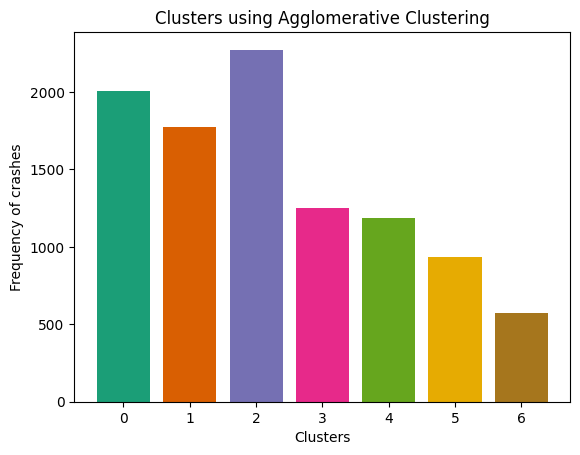

In [ ]:
# run this
cluster_labels = list(set(list(X_hier_loc["LOCATION_CLUSTER"])))
cluster_labels.sort()

frequency = []
for i in cluster_labels:
    frequency.append(list(X_hier_loc["LOCATION_CLUSTER"]).count(i))
bar = plt.bar(cluster_labels, frequency, color=plt.cm.Dark2(np.arange(len(cluster_labels))))

plt.title("Clusters using Agglomerative Clustering")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
# plt.ylim(0,400)
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

## 2) DBSCAN

In [33]:
X_hier_loc = pd.read_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/location_sample_part2.csv")

In [34]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = DBSCAN(eps =0.01
                       , min_samples=100)
      # fit model and predict clusters
        yhat = model.fit_predict(X_hier_loc)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
dbscan_labels = gpu()


Number of clusters:  8
Number of noise points:  6884


In [35]:
X_hier_loc["DBSCAN_LABELS"] = dbscan_labels

In [36]:
X_hier_wo_noise = X_hier_loc[X_hier_loc["DBSCAN_LABELS"] != -1]

In [39]:
data = X_hier_wo_noise[["LATITUDE", "LONGITUDE"]]
labels = list(X_hier_wo_noise["DBSCAN_LABELS"])

In [40]:
metrics.silhouette_score(data, labels, metric='euclidean')

0.4682474517981711

In [ ]:
fig = px.scatter_mapbox(X_hier_wo_noise, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="DBSCAN_LABELS",
                        zoom=8, 
                        height=500,
                        width=1000)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Insights: Hierarchical: Cluster 0

In [ ]:
X_hier_cluster_0 = X_hier[X_hier["LOCATION_CLUSTER"] == 0]

In [ ]:
with open('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/le_list.pkl', 'rb') as f:
    le_list = pickle.load(f)

What is the most common weather condition while accidents happened in this region?

In [ ]:
X_hier_cluster_0["WEATHER_CONDITION_TRANSFORMED"].value_counts()

2     1516
7      174
11     115
10      80
3       46
6        5
4        4
1        3
5        3
9        2
8        1
Name: WEATHER_CONDITION_TRANSFORMED, dtype: int64

In [ ]:
weather_le = le_list[3]
output = list(weather_le.inverse_transform([2,7]))
print(output)

['CLEAR', 'RAIN', 'UNKNOWN']


What is the primary cause of accidents in this region?

In [ ]:
X_hier_cluster_0["PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED"].value_counts()

36    795
18    225
19    210
23    107
21     84
17     71
22     71
24     65
26     60
12     56
39     37
6      18
28     17
38     17
5      14
8      12
30     11
37     11
32     10
13      9
11      9
33      7
2       6
16      4
14      3
4       3
9       3
3       3
0       3
15      2
10      2
29      2
20      2
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
prim_le = le_list[11]
output = list(prim_le.inverse_transform([36,18,19]))
print(output)

['UNABLE TO DETERMINE', 'FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY']


Was there any road defects in this region where the accidents occurred?

In [ ]:
X_hier_cluster_0['ROAD_DEFECT_TRANSFORMED'].value_counts()

1    1503
5     407
3      16
2      14
6       6
4       2
0       1
Name: ROAD_DEFECT_TRANSFORMED, dtype: int64

In [ ]:
defect_le = le_list[9]
output = list(defect_le.inverse_transform([1,5,3,2,6]))
print(output)

['NO DEFECTS', 'UNKNOWN', 'RUT, HOLES', 'OTHER', 'WORN SURFACE']


When did the accidents occur most in this region?

In [ ]:
X_hier_cluster_0['CRASH_HOUR'].value_counts()

17    163
15    138
12    132
16    131
14    131
13    129
18    126
8     121
11    105
9      97
19     93
10     90
7      90
20     74
21     68
22     59
23     43
6      33
2      27
0      24
4      22
1      21
5      17
3      15
Name: CRASH_HOUR, dtype: int64

In [ ]:
X_hier_cluster_0['CRASH_DAY_OF_WEEK'].value_counts()

6    344
5    293
7    281
4    280
3    265
2    258
1    228
Name: CRASH_DAY_OF_WEEK, dtype: int64

## 3) K Means

In [41]:
X_hier_loc = pd.read_csv("/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/location_sample_part2.csv")

In [42]:
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto")
kmeans.fit(X_hier_loc)
clusters = kmeans.labels_

In [43]:
metrics.silhouette_score(X_hier_loc, clusters, metric='euclidean')

0.4153079787314374

In [ ]:
X_hier_loc["KMEANS_LABELS"] = clusters

In [ ]:
fig = px.scatter_mapbox(X_hier_loc, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="KMEANS_LABELS",
                        zoom=8, 
                        height=500,
                        width=1000)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Suggestions: accidents that correspond to a certain type only. subsets of accidents and question: is there any difference b etween different types of accidents. Is there certain areas where there are certain types of accidents. Take a subset of accident type -> generate insight based on that accident (time, weather).

In [ ]:
# run this
cluster_labels = list(set(list(X_hier_loc["KMEANS_LABELS"])))
cluster_labels.sort()

frequency = []
for i in cluster_labels:
    frequency.append(list(X_hier_loc["KMEANS_LABELS"]).count(i))
bar = plt.bar(cluster_labels, frequency, color=plt.cm.Dark2(np.arange(len(cluster_labels))))

plt.title("Clusters using KMEANS for RQ2")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
# plt.ylim(0,400)
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

# We all consider subsets of accidents and try to find what are the most common places for that particular category. There are 40 different categories, we will consider 6 of the objective accident types.


FAILING TO REDUCE SPEED TO AVOID CRASH

DISREGARDING TRAFFIC SIGNALS

DISREGARDING STOP SIGN

VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)

EXCEEDING AUTHORIZED SPEED LIMIT        

ROAD ENGINEERING/SURFACE/MARKING DEFECTS

In [ ]:
df.columns

Index(['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'DAMAGE',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE',
       'LOCATION'],
      dtype='object')

In [ ]:
df3 = df[df["PRIM_CONTRIBUTORY_CAUSE"] == "FAILING TO REDUCE SPEED TO AVOID CRASH"] # west jackson boulevard, west madison street | west garfield park | university of illinois chicago | central side of chicago
df4 = df[df["PRIM_CONTRIBUTORY_CAUSE"] == "DISREGARDING TRAFFIC SIGNALS"] # Eisenhower expressway | Central area | Dan Ryan Expressway
df5 = df[df["PRIM_CONTRIBUTORY_CAUSE"] == "DISREGARDING STOP SIGN"] # Greater Grand crossing | Grand Boulevard
df6 = df[df["PRIM_CONTRIBUTORY_CAUSE"] == "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)"] # Hyde Park | McKinley Park | Near North side | around near west side | North Kedzie avenue | west devon avenue | Near Roger's park
df7 = df[df["PRIM_CONTRIBUTORY_CAUSE"] == "EXCEEDING AUTHORIZED SPEED LIMIT"] # North western university chicago campus | west madison street | Eisenhower expressway
df8 = df[df["PRIM_CONTRIBUTORY_CAUSE"] == "ROAD ENGINEERING/SURFACE/MARKING DEFECTS"] # Road US 41

In [ ]:
# run this
X_hier = df8.copy()
X_hier_loc = X_hier[["LATITUDE", "LONGITUDE"]].copy()

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = DBSCAN(eps =0.005, min_samples=20) # model = DBSCAN(eps =0.005, min_samples=100) df3 = 150, df4, df5, df8 =100, df6 = 25, df7 = 20
      # fit model and predict clusters
        yhat = model.fit_predict(X_hier_loc)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
dbscan_labels = gpu()


Number of clusters:  4
Number of noise points:  1620


In [ ]:
X_hier_loc["DBSCAN_LABELS"] = dbscan_labels

In [ ]:
X_hier_wo_noise = X_hier_loc[X_hier_loc["DBSCAN_LABELS"] != -1]

In [ ]:
fig = px.scatter_mapbox(X_hier_wo_noise, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="DBSCAN_LABELS",
                        zoom=8, 
                        height=500,
                        width=1000)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# RQ3: Pattern between different contributing Factor

In [44]:
X = df.copy()

In [45]:
X = X.drop(["POSTED_SPEED_LIMIT", "FIRST_CRASH_TYPE", "ROAD_DEFECT", "SEC_CONTRIBUTORY_CAUSE", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "LATITUDE", "LONGITUDE", "LOCATION" ], axis = 1)

In [ ]:
df.head()

POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
0                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
1                  30            NO CONTROLS           NO CONTROLS   
2                  30                UNKNOWN               UNKNOWN   
3                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
4                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   

  WEATHER_CONDITION      LIGHTING_CONDITION FIRST_CRASH_TYPE TRAFFICWAY_TYPE  \
0             CLEAR                DAYLIGHT          TURNING         ONE-WAY   
1             CLEAR                DAYLIGHT            ANGLE     NOT DIVIDED   
2             CLEAR  DARKNESS, LIGHTED ROAD            ANGLE     NOT DIVIDED   
3             CLEAR                DAYLIGHT         REAR END        FOUR WAY   
4             CLEAR                DAYLIGHT         REAR END     NOT DIVIDED   

  ROADWAY_SURFACE_COND ROAD_DEFECT         DAMAGE  \
0                  DRY  NO DEFECTS    OVER $1,500   
1                  DRY  NO DEFECTS    OVER $1,500   
2                  DRY     UNKNOWN    OVER $1,500   
3                  DRY  NO DEFECTS  $501 - $1,500   
4                  DRY  NO DEFECTS    OVER $1,500   

                             PRIM_CONTRIBUTORY_CAUSE  \
0                         IMPROPER TURNING/NO SIGNAL   
1  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...   
2                                UNABLE TO DETERMINE   
3                       DISREGARDING TRAFFIC SIGNALS   
4                                UNABLE TO DETERMINE   

                SEC_CONTRIBUTORY_CAUSE  CRASH_HOUR  CRASH_DAY_OF_WEEK  \
0  DRIVING SKILLS/KNOWLEDGE/EXPERIENCE          14                  2   
1        FAILING TO YIELD RIGHT-OF-WAY           8                  4   
2                  UNABLE TO DETERMINE           0                  6   
3                       NOT APPLICABLE          11                  2   
4                  UNABLE TO DETERMINE          18                  6   

   CRASH_MONTH   LATITUDE  LONGITUDE                                  LOCATION  
0            3  41.884547 -87.641201   POINT (-87.64120093714 41.884547224337)  
1            9  41.968562 -87.740659  POINT (-87.740659314632 41.968562453871)  
2            7  41.886336 -87.716203  POINT (-87.716203130599 41.886336409761)  
3            8  41.749348 -87.721097  POINT (-87.721096727406 41.749348170421)  
4            7  41.925111 -87.667997  POINT (-87.667997321599 41.925110815832)

In [10]:
X.head()

TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
1            NO CONTROLS           NO CONTROLS             CLEAR   
2                UNKNOWN               UNKNOWN             CLEAR   
3         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
4         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   

       LIGHTING_CONDITION TRAFFICWAY_TYPE ROADWAY_SURFACE_COND         DAMAGE  \
0                DAYLIGHT         ONE-WAY                  DRY    OVER $1,500   
1                DAYLIGHT     NOT DIVIDED                  DRY    OVER $1,500   
2  DARKNESS, LIGHTED ROAD     NOT DIVIDED                  DRY    OVER $1,500   
3                DAYLIGHT        FOUR WAY                  DRY  $501 - $1,500   
4                DAYLIGHT     NOT DIVIDED                  DRY    OVER $1,500   

                             PRIM_CONTRIBUTORY_CAUSE  
0                         IMPROPER TURNING/NO SIGNAL  
1  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...  
2                                UNABLE TO DETERMINE  
3                       DISREGARDING TRAFFIC SIGNALS  
4                                UNABLE TO DETERMINE

In [ ]:
df["WEATHER_CONDITION"].value_counts()

CLEAR                       545661
RAIN                         59611
UNKNOWN                      34796
SNOW                         25737
CLOUDY/OVERCAST              20345
OTHER                         2211
FREEZING RAIN/DRIZZLE         1235
FOG/SMOKE/HAZE                1026
SLEET/HAIL                     901
BLOWING SNOW                   363
SEVERE CROSS WIND GATE         135
BLOWING SAND, SOIL, DIRT         4
Name: WEATHER_CONDITION, dtype: int64

In [ ]:
df["LIGHTING_CONDITION"].value_counts()

DAYLIGHT                  444830
DARKNESS, LIGHTED ROAD    153101
DARKNESS                   33338
UNKNOWN                    28903
DUSK                       20293
DAWN                       11560
Name: LIGHTING_CONDITION, dtype: int64

In [ ]:
df["ROADWAY_SURFACE_COND"].value_counts()

DRY                513593
WET                 92085
UNKNOWN             53230
SNOW OR SLUSH       25995
ICE                  5105
OTHER                1746
SAND, MUD, DIRT       271
Name: ROADWAY_SURFACE_COND, dtype: int64

In [ ]:
df["ROAD_DEFECT"].value_counts()

NO DEFECTS           564889
UNKNOWN              112962
RUT, HOLES             5566
OTHER                  3860
WORN SURFACE           2856
SHOULDER DEFECT        1348
DEBRIS ON ROADWAY       544
Name: ROAD_DEFECT, dtype: int64

In [ ]:
df["DEVICE_CONDITION"].value_counts()

NO CONTROLS                 401223
FUNCTIONING PROPERLY        238327
UNKNOWN                      41344
OTHER                         5301
FUNCTIONING IMPROPERLY        3355
NOT FUNCTIONING               2138
WORN REFLECTIVE MATERIAL       257
MISSING                         80
Name: DEVICE_CONDITION, dtype: int64

In [ ]:
df["DAMAGE"].value_counts()

OVER $1,500      420198
$501 - $1,500    190348
$500 OR LESS      81479
Name: DAMAGE, dtype: int64

In [33]:
df["TRAFFICWAY_TYPE"].value_counts()

NOT DIVIDED                        305295
DIVIDED - W/MEDIAN (NOT RAISED)    114572
ONE-WAY                             89102
PARKING LOT                         47300
DIVIDED - W/MEDIAN BARRIER          39987
FOUR WAY                            36061
OTHER                               18731
ALLEY                               11470
UNKNOWN                              7693
T-INTERSECTION                       7440
CENTER TURN LANE                     5188
DRIVEWAY                             2278
RAMP                                 2080
UNKNOWN INTERSECTION TYPE            1843
FIVE POINT, OR MORE                   825
Y-INTERSECTION                        803
TRAFFIC ROUTE                         653
NOT REPORTED                          382
ROUNDABOUT                            197
L-INTERSECTION                        125
Name: TRAFFICWAY_TYPE, dtype: int64

## Considering all categorical columns

In [11]:
X_new = X.copy()
X_new = X_new.sample(frac = 1)[:10000]
X_new = X_new.reset_index()

In [19]:
#df.to_csv('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/Crashes_processed.csv', index = False)
X_new.to_csv('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/data_rq3.csv', index = False)

In [46]:
X_new = pd.read_csv('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Dataset/data_rq3.csv')
X_alg = X_new.drop(["index"], axis = 1)

In [47]:
distance_matrix = gower.gower_matrix(X_alg)

In [48]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = DBSCAN(eps =0.005
                       , min_samples=70, metric = "precomputed")
      # fit model and predict clusters
        yhat = model.fit_predict(distance_matrix)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
dbscan_labels = gpu()


Number of clusters:  8
Number of noise points:  8967


In [49]:
X_alg["DBSCAN_LABELS"] = dbscan_labels

In [15]:
latitudes = []
longitudes = []
for i in range(len(X_alg)):
  latitudes.append(df["LATITUDE"][X_new['index'][i]])
  longitudes.append(df["LONGITUDE"][X_new['index'][i]])

X_alg["LATITUDE"] = latitudes
X_alg["LONGITUDE"] = longitudes

In [50]:
X_alg_wo_noise = X_alg[X_alg["DBSCAN_LABELS"] != -1]

In [1]:
X_alg_wo_noise.head()

NameError: ignored

In [17]:
X_alg_wo_noise["DBSCAN_LABELS"].value_counts()

1    266
0    194
4    120
5     97
6     95
2     94
3     90
7     77
Name: DBSCAN_LABELS, dtype: int64

In [44]:
X_alg_cluster3 = X_alg_wo_noise[X_alg_wo_noise["DBSCAN_LABELS"] == 3]
print(X_alg_cluster3["TRAFFICWAY_TYPE"].value_counts())
print(X_alg_cluster3["DAMAGE"].value_counts())
print(X_alg_cluster3["WEATHER_CONDITION"].value_counts())
print(X_alg_cluster3["LIGHTING_CONDITION"].value_counts())
print(X_alg_cluster3["DEVICE_CONDITION"].value_counts())
print(X_alg_cluster3["TRAFFIC_CONTROL_DEVICE"].value_counts())
print(X_alg_cluster3["ROADWAY_SURFACE_COND"].value_counts())
print(X_alg_cluster3["PRIM_CONTRIBUTORY_CAUSE"].value_counts())

NOT DIVIDED    270
Name: TRAFFICWAY_TYPE, dtype: int64
OVER $1,500    270
Name: DAMAGE, dtype: int64
CLEAR    270
Name: WEATHER_CONDITION, dtype: int64
DAYLIGHT    270
Name: LIGHTING_CONDITION, dtype: int64
NO CONTROLS    270
Name: DEVICE_CONDITION, dtype: int64
NO CONTROLS    270
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
DRY    270
Name: ROADWAY_SURFACE_COND, dtype: int64
UNABLE TO DETERMINE    270
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


In [45]:
X_alg_cluster3 = X_alg_wo_noise[X_alg_wo_noise["DBSCAN_LABELS"] == 2]
print(X_alg_cluster3["TRAFFICWAY_TYPE"].value_counts())
print(X_alg_cluster3["DAMAGE"].value_counts())
print(X_alg_cluster3["WEATHER_CONDITION"].value_counts())
print(X_alg_cluster3["LIGHTING_CONDITION"].value_counts())
print(X_alg_cluster3["DEVICE_CONDITION"].value_counts())
print(X_alg_cluster3["TRAFFIC_CONTROL_DEVICE"].value_counts())
print(X_alg_cluster3["ROADWAY_SURFACE_COND"].value_counts())
print(X_alg_cluster3["PRIM_CONTRIBUTORY_CAUSE"].value_counts())

NOT DIVIDED    161
Name: TRAFFICWAY_TYPE, dtype: int64
$501 - $1,500    161
Name: DAMAGE, dtype: int64
CLEAR    161
Name: WEATHER_CONDITION, dtype: int64
DAYLIGHT    161
Name: LIGHTING_CONDITION, dtype: int64
NO CONTROLS    161
Name: DEVICE_CONDITION, dtype: int64
NO CONTROLS    161
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
DRY    161
Name: ROADWAY_SURFACE_COND, dtype: int64
UNABLE TO DETERMINE    161
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


In [46]:
X_alg_cluster3 = X_alg_wo_noise[X_alg_wo_noise["DBSCAN_LABELS"] == 6]
print(X_alg_cluster3["TRAFFICWAY_TYPE"].value_counts())
print(X_alg_cluster3["DAMAGE"].value_counts())
print(X_alg_cluster3["WEATHER_CONDITION"].value_counts())
print(X_alg_cluster3["LIGHTING_CONDITION"].value_counts())
print(X_alg_cluster3["DEVICE_CONDITION"].value_counts())
print(X_alg_cluster3["TRAFFIC_CONTROL_DEVICE"].value_counts())
print(X_alg_cluster3["ROADWAY_SURFACE_COND"].value_counts())
print(X_alg_cluster3["PRIM_CONTRIBUTORY_CAUSE"].value_counts())

ONE-WAY    113
Name: TRAFFICWAY_TYPE, dtype: int64
OVER $1,500    113
Name: DAMAGE, dtype: int64
CLEAR    113
Name: WEATHER_CONDITION, dtype: int64
DAYLIGHT    113
Name: LIGHTING_CONDITION, dtype: int64
NO CONTROLS    113
Name: DEVICE_CONDITION, dtype: int64
NO CONTROLS    113
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
DRY    113
Name: ROADWAY_SURFACE_COND, dtype: int64
UNABLE TO DETERMINE    113
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


In [47]:
X_alg_cluster3 = X_alg_wo_noise[X_alg_wo_noise["DBSCAN_LABELS"] == 0]
print(X_alg_cluster3["TRAFFICWAY_TYPE"].value_counts())
print(X_alg_cluster3["DAMAGE"].value_counts())
print(X_alg_cluster3["WEATHER_CONDITION"].value_counts())
print(X_alg_cluster3["LIGHTING_CONDITION"].value_counts())
print(X_alg_cluster3["DEVICE_CONDITION"].value_counts())
print(X_alg_cluster3["TRAFFIC_CONTROL_DEVICE"].value_counts())
print(X_alg_cluster3["ROADWAY_SURFACE_COND"].value_counts())
print(X_alg_cluster3["PRIM_CONTRIBUTORY_CAUSE"].value_counts())

NOT DIVIDED    100
Name: TRAFFICWAY_TYPE, dtype: int64
OVER $1,500    100
Name: DAMAGE, dtype: int64
CLEAR    100
Name: WEATHER_CONDITION, dtype: int64
DAYLIGHT    100
Name: LIGHTING_CONDITION, dtype: int64
FUNCTIONING PROPERLY    100
Name: DEVICE_CONDITION, dtype: int64
TRAFFIC SIGNAL    100
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
DRY    100
Name: ROADWAY_SURFACE_COND, dtype: int64
UNABLE TO DETERMINE    100
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


In [48]:
X_alg_cluster3 = X_alg_wo_noise[X_alg_wo_noise["DBSCAN_LABELS"] == 4]
print(X_alg_cluster3["TRAFFICWAY_TYPE"].value_counts())
print(X_alg_cluster3["DAMAGE"].value_counts())
print(X_alg_cluster3["WEATHER_CONDITION"].value_counts())
print(X_alg_cluster3["LIGHTING_CONDITION"].value_counts())
print(X_alg_cluster3["DEVICE_CONDITION"].value_counts())
print(X_alg_cluster3["TRAFFIC_CONTROL_DEVICE"].value_counts())
print(X_alg_cluster3["ROADWAY_SURFACE_COND"].value_counts())
print(X_alg_cluster3["PRIM_CONTRIBUTORY_CAUSE"].value_counts())

NOT DIVIDED    95
Name: TRAFFICWAY_TYPE, dtype: int64
OVER $1,500    95
Name: DAMAGE, dtype: int64
CLEAR    95
Name: WEATHER_CONDITION, dtype: int64
DAYLIGHT    95
Name: LIGHTING_CONDITION, dtype: int64
NO CONTROLS    95
Name: DEVICE_CONDITION, dtype: int64
NO CONTROLS    95
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
DRY    95
Name: ROADWAY_SURFACE_COND, dtype: int64
FAILING TO YIELD RIGHT-OF-WAY    95
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


In [49]:
X_alg_cluster3 = X_alg_wo_noise[X_alg_wo_noise["DBSCAN_LABELS"] == 5]
print(X_alg_cluster3["TRAFFICWAY_TYPE"].value_counts())
print(X_alg_cluster3["DAMAGE"].value_counts())
print(X_alg_cluster3["WEATHER_CONDITION"].value_counts())
print(X_alg_cluster3["LIGHTING_CONDITION"].value_counts())
print(X_alg_cluster3["DEVICE_CONDITION"].value_counts())
print(X_alg_cluster3["TRAFFIC_CONTROL_DEVICE"].value_counts())
print(X_alg_cluster3["ROADWAY_SURFACE_COND"].value_counts())
print(X_alg_cluster3["PRIM_CONTRIBUTORY_CAUSE"].value_counts())

NOT DIVIDED    91
Name: TRAFFICWAY_TYPE, dtype: int64
OVER $1,500    91
Name: DAMAGE, dtype: int64
CLEAR    91
Name: WEATHER_CONDITION, dtype: int64
DARKNESS, LIGHTED ROAD    91
Name: LIGHTING_CONDITION, dtype: int64
NO CONTROLS    91
Name: DEVICE_CONDITION, dtype: int64
NO CONTROLS    91
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
DRY    91
Name: ROADWAY_SURFACE_COND, dtype: int64
UNABLE TO DETERMINE    91
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


In [18]:
X_alg_cluster3 = X_alg_wo_noise[X_alg_wo_noise["DBSCAN_LABELS"] == 1]
print(X_alg_cluster3["TRAFFICWAY_TYPE"].value_counts())
print(X_alg_cluster3["DAMAGE"].value_counts())
print(X_alg_cluster3["WEATHER_CONDITION"].value_counts())
print(X_alg_cluster3["LIGHTING_CONDITION"].value_counts())
print(X_alg_cluster3["DEVICE_CONDITION"].value_counts())
print(X_alg_cluster3["TRAFFIC_CONTROL_DEVICE"].value_counts())
print(X_alg_cluster3["ROADWAY_SURFACE_COND"].value_counts())
print(X_alg_cluster3["PRIM_CONTRIBUTORY_CAUSE"].value_counts())

NOT DIVIDED    266
Name: TRAFFICWAY_TYPE, dtype: int64
OVER $1,500    266
Name: DAMAGE, dtype: int64
CLEAR    266
Name: WEATHER_CONDITION, dtype: int64
DAYLIGHT    266
Name: LIGHTING_CONDITION, dtype: int64
NO CONTROLS    266
Name: DEVICE_CONDITION, dtype: int64
NO CONTROLS    266
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
DRY    266
Name: ROADWAY_SURFACE_COND, dtype: int64
UNABLE TO DETERMINE    266
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


In [51]:
X_alg_cluster3 = X_alg_wo_noise[X_alg_wo_noise["DBSCAN_LABELS"] == 7]
print(X_alg_cluster3["TRAFFICWAY_TYPE"].value_counts())
print(X_alg_cluster3["DAMAGE"].value_counts())
print(X_alg_cluster3["WEATHER_CONDITION"].value_counts())
print(X_alg_cluster3["LIGHTING_CONDITION"].value_counts())
print(X_alg_cluster3["DEVICE_CONDITION"].value_counts())
print(X_alg_cluster3["TRAFFIC_CONTROL_DEVICE"].value_counts())
print(X_alg_cluster3["ROADWAY_SURFACE_COND"].value_counts())
print(X_alg_cluster3["PRIM_CONTRIBUTORY_CAUSE"].value_counts())

DIVIDED - W/MEDIAN (NOT RAISED)    72
Name: TRAFFICWAY_TYPE, dtype: int64
OVER $1,500    72
Name: DAMAGE, dtype: int64
CLEAR    72
Name: WEATHER_CONDITION, dtype: int64
DAYLIGHT    72
Name: LIGHTING_CONDITION, dtype: int64
NO CONTROLS    72
Name: DEVICE_CONDITION, dtype: int64
NO CONTROLS    72
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
DRY    72
Name: ROADWAY_SURFACE_COND, dtype: int64
UNABLE TO DETERMINE    72
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


## K-modes

In [55]:
# monday
km = KModes(n_clusters=8, init='Huang', n_init=10, verbose=1)
clusters = km.fit_predict(X_alg)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3479, cost: 24201.0
Run 1, iteration: 2/100, moves: 1473, cost: 24201.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1712, cost: 22067.0
Run 2, iteration: 2/100, moves: 129, cost: 22067.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2759, cost: 21763.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3256, cost: 21870.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3043, cost: 21932.0
Run 5, iteration: 2/100, moves: 502, cost: 21686.0
Run 5, iteration: 3/100, moves: 113, cost: 21686.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 2181, cost: 21512.0
Run

## week day wise accident primary contributing cause and location

In [ ]:
X_mon = X[X["CRASH_DAY_OF_WEEK"] == 2]

In [ ]:
X_mon_night = X_mon[(X_mon["CRASH_HOUR"] >= 0) & (X_mon["CRASH_HOUR"] < 7) ]
# [['FAILING TO YIELD RIGHT-OF-WAY']
#  ['FAILING TO REDUCE SPEED TO AVOID CRASH']
#  ['NOT APPLICABLE']
#  ['FOLLOWING TOO CLOSELY']
#  ['UNABLE TO DETERMINE']]
X_mon_morning = X_mon[(X_mon["CRASH_HOUR"] >= 7) & (X_mon["CRASH_HOUR"] < 9) ]
# [['FOLLOWING TOO CLOSELY']
#  ['ROAD ENGINEERING/SURFACE/MARKING DEFECTS']
#  ['FAILING TO YIELD RIGHT-OF-WAY']
#  ['UNABLE TO DETERMINE']
#  ['EQUIPMENT - VEHICLE CONDITION']]
X_mon_office = X_mon[(X_mon["CRASH_HOUR"] >= 9) & (X_mon["CRASH_HOUR"] < 17) ]
# [['NOT APPLICABLE']
#  ['FOLLOWING TOO CLOSELY']
#  ['FAILING TO YIELD RIGHT-OF-WAY']
#  ['UNABLE TO DETERMINE']
#  ['IMPROPER OVERTAKING/PASSING']]
X_mon_after_office = X_mon[(X_mon["CRASH_HOUR"] >= 17) & (X_mon["CRASH_HOUR"] < 21) ]
# [['UNABLE TO DETERMINE']
#  ['FOLLOWING TOO CLOSELY']
#  ['IMPROPER TURNING/NO SIGNAL']
#  ['DRIVING SKILLS/KNOWLEDGE/EXPERIENCE']
#  ['FAILING TO YIELD RIGHT-OF-WAY']]
X_mon_evening = X_mon[X_mon["CRASH_HOUR"] >= 21]
# [['UNABLE TO DETERMINE']
#  ['FAILING TO YIELD RIGHT-OF-WAY']
#  ['IMPROPER LANE USAGE']
#  ['FOLLOWING TOO CLOSELY']
#  ['FAILING TO REDUCE SPEED TO AVOID CRASH']]

K-modes

In [ ]:
# monday
km = KModes(n_clusters=5, init='Huang', n_init=10, verbose=1)
data = np.array(list(X_mon_evening["PRIM_CONTRIBUTORY_CAUSE"]))
data = data.reshape(data.shape[0], 1)

clusters = km.fit_predict(data)

# Print the cluster centroids
print(km.cluster_centroids_)

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = DBSCAN(eps =0.005
                       , min_samples=37)
      # fit model and predict clusters
        yhat = model.fit_predict(X_mon_evening[["LATITUDE", "LONGITUDE"]])
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
dbscan_labels = gpu()


Number of clusters:  4
Number of noise points:  5962


In [ ]:
X_mon_evening["DBSCAN_LABELS"] = dbscan_labels

In [ ]:
X_mon_morning_wo_noise = X_mon_evening[X_mon_evening["DBSCAN_LABELS"] != -1]

In [ ]:
fig = px.scatter_mapbox(X_mon_morning_wo_noise, 
                        lat="LATITUDE", 
                        lon="LONGITUDE", 
                        color="DBSCAN_LABELS",
                        zoom=8, 
                        height=500,
                        width=1000)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
X = X_mon_night[['PRIM_CONTRIBUTORY_CAUSE']]
distance_matrix = gower.gower_matrix(X)

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = DBSCAN(eps =0.005
                       , min_samples=400, metric = "precomputed")
      # fit model and predict clusters
        yhat = model.fit_predict(distance_matrix)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
dbscan_labels = gpu()


Number of clusters:  5
Number of noise points:  3340


In [ ]:
X["DBSCAN_LABELS"] = dbscan_labels

In [ ]:
X_0 = X[X["DBSCAN_LABELS"] == 4]

In [ ]:
X_0["PRIM_CONTRIBUTORY_CAUSE"].value_counts()

FOLLOWING TOO CLOSELY    592
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64

## Correlation Between Different Factors

In [ ]:
X_factors = df[['TRAFFIC_CONTROL_DEVICE_TRANSFORMED','DEVICE_CONDITION_TRANSFORMED', 'WEATHER_CONDITION_TRANSFORMED','LIGHTING_CONDITION_TRANSFORMED', 'FIRST_CRASH_TYPE_TRANSFORMED', 'ROADWAY_SURFACE_COND_TRANSFORMED', 'ROAD_DEFECT_TRANSFORMED', 'PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED','SEC_CONTRIBUTORY_CAUSE_TRANSFORMED', "CRASH_DAY_OF_WEEK", "CRASH_HOUR", "LOCATION_TRANSFORMED"]]

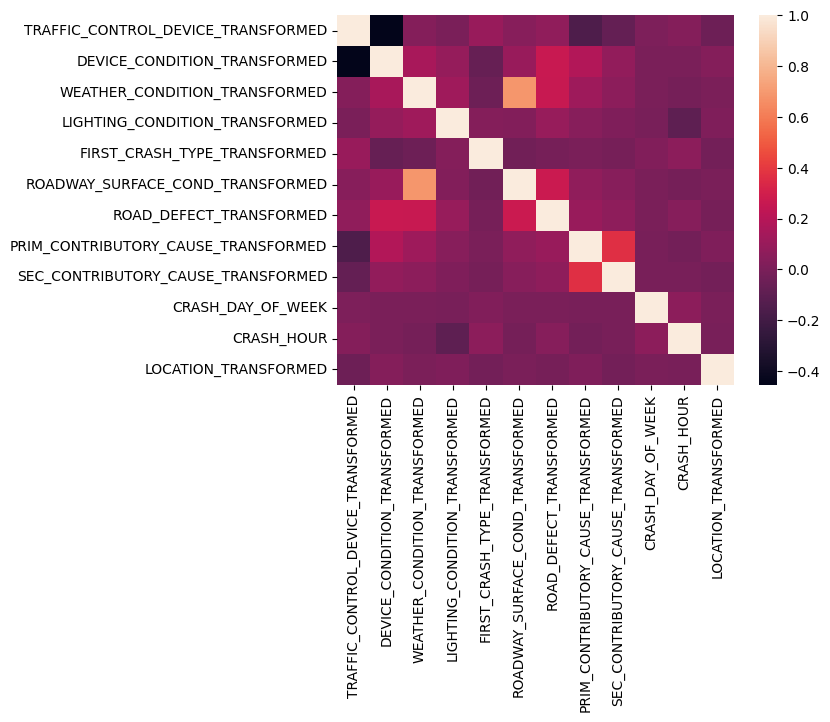

In [ ]:
sns.heatmap(X_factors.corr());

We can see from the heatmap that the time and location of the crash is not positively correlated with any of the other factors. However, we see a highly positive correlation between the roadway surface condition and weather condition. Similarly, a positive correlation exists between road defect and weather and road defect and traffic device condition. Also, a small positive correlation exists between the primary and secondary contributing cause of the accidents.

In [ ]:
# run this
X_new = df[['ROADWAY_SURFACE_COND_TRANSFORMED', 'ROAD_DEFECT_TRANSFORMED', "WEATHER_CONDITION_TRANSFORMED"]].copy()

## 1) KMeans

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto")
kmeans.fit(X_new)
clusters = kmeans.labels_

In [ ]:
clusters = kmeans.labels_

filtered_label0 = len(X_new[clusters == 0])
filtered_label1 = len(X_new[clusters == 1])
filtered_label2 = len(X_new[clusters == 2])
filtered_label3 = len(X_new[clusters == 3])
filtered_label4 = len(X_new[clusters == 4])

cluster_labels = [0,1,2, 3,4]
frequency = [filtered_label0, filtered_label1, filtered_label2, filtered_label3, filtered_label4]

bar = plt.bar(cluster_labels, frequency, color = ['red', 'black', 'green', 'blue', 'yellow'])

plt.title("Clusters using KMeans for RQ3")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

In [ ]:
cluster_2 = X_new[clusters == 2]

In [ ]:
cluster_2.head()

ROADWAY_SURFACE_COND_TRANSFORMED  ROAD_DEFECT_TRANSFORMED  \
0                                 0                        1   
1                                 0                        1   
3                                 0                        1   
4                                 0                        1   
5                                 0                        1   

   WEATHER_CONDITION_TRANSFORMED  
0                              2  
1                              2  
3                              2  
4                              2  
5                              2

In [ ]:
cluster_2["ROADWAY_SURFACE_COND_TRANSFORMED"].value_counts()

0    458034
1      2797
2       561
3        29
4        12
Name: ROADWAY_SURFACE_COND_TRANSFORMED, dtype: int64

In [ ]:
surface_le = le_list[8]
output = list(surface_le.inverse_transform([0,1]))
print(output)

['DRY', 'ICE']


In [ ]:
cluster_2["WEATHER_CONDITION_TRANSFORMED"].value_counts()

2    447079
3     11293
7      1870
6       621
4       367
5       169
1        32
0         2
Name: WEATHER_CONDITION_TRANSFORMED, dtype: int64

In [ ]:
weather_le = le_list[3]
output = list(weather_le.inverse_transform([2,3,7]))
print(output)

['CLEAR', 'CLOUDY/OVERCAST', 'RAIN']


In [ ]:
cluster_2["ROAD_DEFECT_TRANSFORMED"].value_counts()

1    455125
3      3657
2      2225
0       426
Name: ROAD_DEFECT_TRANSFORMED, dtype: int64

In [ ]:
defect_le = le_list[9]
output = list(defect_le.inverse_transform([1,3,2]))
print(output)

['NO DEFECTS', 'RUT, HOLES', 'OTHER']


Insight: According to KMeans, we can say that, the most common road surfaces during accidents are ['DRY', 'ICE'], weather conditions: ['CLEAR', 'CLOUDY/OVERCAST', 'RAIN'] and road defects: ['NO DEFECTS', 'RUT, HOLES', 'OTHER']. We can imagine that ice and rain makes roads slippery and this could cause accidents. In addition, cloudy sky could make the surrounding difficult to visualize which could also cause accidents. And rut or holes in roads are one of the major reasons for accidents.

## 2) DBSCAN

In [ ]:
X_dbscan = X_new.sample(frac = 1)[:20000]

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = DBSCAN(eps=0.15, min_samples=50)
      # fit model and predict clusters
        yhat = model.fit_predict(X_dbscan)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
dbscan_labels = gpu()


Number of clusters:  22
Number of noise points:  716


In [ ]:
cluster_labels = list(set(list(dbscan_labels)))
cluster_labels.sort()

frequency = []
for i in cluster_labels:
    frequency.append(list(dbscan_labels).count(i))
bar = plt.bar(cluster_labels, frequency, color=plt.cm.Dark2(np.arange(len(cluster_labels))))

plt.title("Clusters using DBSCAN")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")

#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

In [ ]:
X_dbscan["DBSCAN_LABELS"] = dbscan_labels

In [ ]:
cluster_0 = X_dbscan[X_dbscan["DBSCAN_LABELS"] == 0]

In [ ]:
cluster_0["ROADWAY_SURFACE_COND_TRANSFORMED"].value_counts()

0    12627
Name: ROADWAY_SURFACE_COND_TRANSFORMED, dtype: int64

In [ ]:
surface_le = le_list[8]
output = list(surface_le.inverse_transform([0]))
print(output)

['DRY']


In [ ]:
cluster_0["WEATHER_CONDITION_TRANSFORMED"].value_counts()

2    12627
Name: WEATHER_CONDITION_TRANSFORMED, dtype: int64

In [ ]:
weather_le = le_list[3]
output = list(weather_le.inverse_transform([2]))
print(output)

['CLEAR']


In [ ]:
cluster_0["ROAD_DEFECT_TRANSFORMED"].value_counts()

1    12627
Name: ROAD_DEFECT_TRANSFORMED, dtype: int64

In [ ]:
defect_le = le_list[9]
output = list(defect_le.inverse_transform([1]))
print(output)

['NO DEFECTS']


Insight: Difficult to generate any insight from the largest cluster

## 3) Optics

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = OPTICS(eps=5, min_samples=20)
      # fit model and predict clusters
        yhat = model.fit_predict(X_dbscan)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
optics_labels = gpu()


Number of clusters:  357
Number of noise points:  7981


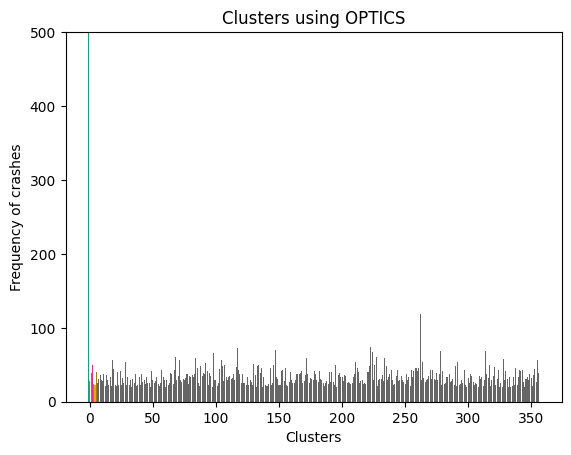

In [ ]:
cluster_labels = list(set(list(optics_labels)))
cluster_labels.sort()

frequency = []
for i in cluster_labels:
    frequency.append(list(optics_labels).count(i))
bar = plt.bar(cluster_labels, frequency, color=plt.cm.Dark2(np.arange(len(cluster_labels))))

plt.title("Clusters using OPTICS")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
plt.ylim(0,500)

#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

In [ ]:
list2 = list(set(frequency))
 
# Sorting the  list
list2.sort()
 
# Printing the second last element
print("Second largest element is:", list2[-2])

Second largest element is: 118


In [ ]:
for i in range(len(frequency)):
  if frequency[i] == 118:
    print(i)

263


In [ ]:
X_dbscan["OPTICS_LABELS"] = optics_labels

In [ ]:
cluster_263 = X_dbscan[X_dbscan["OPTICS_LABELS"] == 263]

In [ ]:
cluster_263["ROADWAY_SURFACE_COND_TRANSFORMED"].value_counts()

0    26
6     1
4     1
5     1
Name: ROADWAY_SURFACE_COND_TRANSFORMED, dtype: int64

In [ ]:
surface_le = le_list[8]
output = list(surface_le.inverse_transform([0]))
print(output)

['DRY']


In [ ]:
cluster_263["WEATHER_CONDITION_TRANSFORMED"].value_counts()

2     27
6      1
11     1
Name: WEATHER_CONDITION_TRANSFORMED, dtype: int64

In [ ]:
weather_le = le_list[3]
output = list(weather_le.inverse_transform([2]))
print(output)

['CLEAR']


In [ ]:
cluster_263["ROAD_DEFECT_TRANSFORMED"].value_counts()

1    21
5     7
3     1
Name: ROAD_DEFECT_TRANSFORMED, dtype: int64

In [ ]:
defect_le = le_list[9]
output = list(defect_le.inverse_transform([1]))
print(output)

['NO DEFECTS']


Insight: Difficult to generate any insight from the largest cluster

## Is there any pattern between the primary and secondary cause of the accidents?

### 1) KMeans

In [ ]:
# run this
X_new = df[['PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED', 'SEC_CONTRIBUTORY_CAUSE_TRANSFORMED']].copy()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto")
kmeans.fit(X_new)
clusters = kmeans.labels_

In [ ]:
clusters = kmeans.labels_

filtered_label0 = len(X_new[clusters == 0])
filtered_label1 = len(X_new[clusters == 1])
filtered_label2 = len(X_new[clusters == 2])
filtered_label3 = len(X_new[clusters == 3])
filtered_label4 = len(X_new[clusters == 4])

cluster_labels = [0,1,2, 3,4]
frequency = [filtered_label0, filtered_label1, filtered_label2, filtered_label3, filtered_label4]

bar = plt.bar(cluster_labels, frequency, color = ['red', 'black', 'green', 'blue', 'yellow'])

plt.title("Clusters using KMeans for RQ3")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")
#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

In [ ]:
cluster_0 = X_new[clusters == 0]

In [ ]:
cluster_0["PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED"].value_counts()

19    45338
26    35897
23    25678
21    20148
18    20032
22    18417
24    18127
17     7989
28     4076
20      549
16      462
15       66
27       47
25       17
29        9
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
cluster_0["SEC_CONTRIBUTORY_CAUSE_TRANSFORMED"].value_counts()

26    106882
36     68140
23      6564
39      4481
24      3463
28      2626
38      1359
22      1247
30       737
37       410
32       287
31       192
35       148
33       126
34        63
29        59
27        43
25        25
Name: SEC_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
prim_le = le_list[11]
second_le = le_list[12]
output1 = list(prim_le.inverse_transform([19,26,23,21,18]))
output2 = list(second_le.inverse_transform([26,36,23,39,24]))
print("Primary reason: ", output1)
print("Secondary reason: ", output2)

Primary reason:  ['FOLLOWING TOO CLOSELY', 'NOT APPLICABLE', 'IMPROPER OVERTAKING/PASSING', 'IMPROPER BACKING', 'FAILING TO YIELD RIGHT-OF-WAY']
Secondary reason:  ['NOT APPLICABLE', 'UNABLE TO DETERMINE', 'IMPROPER OVERTAKING/PASSING', 'WEATHER', 'IMPROPER TURNING/NO SIGNAL']


The primary and secondary reasons mostly are due to the style of driving.

## 2) DBSCAN

In [ ]:
X_dbscan = X_new.sample(frac = 1)[:20000]

In [ ]:
def gpu():
    with tf.device('/device:GPU:0'):
        model = DBSCAN(eps=0.5, min_samples=20)
      # fit model and predict clusters
        yhat = model.fit_predict(X_dbscan)
        # retrieve unique clusters
        clusters = np.unique(yhat)
        noise = 0
        if list(clusters).count(-1) > 0:
            noise = 1
        print("Number of clusters: ", len(clusters) - noise)
        print("Number of noise points: ", list(yhat).count(-1))
        return yhat
dbscan_labels = gpu()


Number of clusters:  93
Number of noise points:  1759


In [ ]:
cluster_labels = list(set(list(dbscan_labels)))
cluster_labels.sort()

frequency = []
for i in cluster_labels:
    frequency.append(list(dbscan_labels).count(i))
bar = plt.bar(cluster_labels, frequency, color=plt.cm.Dark2(np.arange(len(cluster_labels))))

plt.title("Clusters using DBSCAN")
plt.xlabel("Clusters")
plt.ylabel("Frequency of crashes")

#plt.savefig('/content/drive/MyDrive/Winter 23/CMPUT 697/Project/Images/RQ4/Clusters_KMeans_barplot.png')
plt.show()

In [ ]:
X_dbscan["DBSCAN_LABELS"] = dbscan_labels

In [ ]:
cluster_2 = X_dbscan[X_dbscan["DBSCAN_LABELS"] == 2]

In [ ]:
cluster_2["PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED"].value_counts()

36    4515
Name: PRIM_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
cluster_2["SEC_CONTRIBUTORY_CAUSE_TRANSFORMED"].value_counts()

36    4515
Name: SEC_CONTRIBUTORY_CAUSE_TRANSFORMED, dtype: int64

In [ ]:
output1 = list(prim_le.inverse_transform([36]))
output2 = list(second_le.inverse_transform([36]))
print("Primary reason: ", output1)
print("Secondary reason: ", output2)

Primary reason:  ['UNABLE TO DETERMINE']
Secondary reason:  ['UNABLE TO DETERMINE']
